In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import TFViTForImageClassification, ViTConfig, ViTImageProcessor, Trainer, TrainingArguments
from torchvision.transforms import v2
import torch.nn as nn

2026-01-13 13:29:36.014029: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 13:29:36.047232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/cond

In [2]:
# Loading dataset
animal_dataset = load_dataset("imagefolder", data_dir="../../../data/animal_images")
animal_dataset

Resolving data files:   0%|          | 0/30000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2407 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2407
    })
})

In [3]:
# Checking example structure of dataset in training data
features = animal_dataset["train"].features
features

{'image': Image(mode=None, decode=True),
 'label': ClassLabel(names=['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra'])}

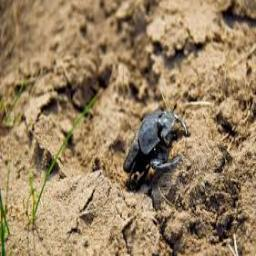

In [4]:
# Visualization of example content of dataset
animal_dataset['train'][10]['image']

In [5]:
# Splitting into seperate datasets to parse onto trainer later on
train_data = animal_dataset["train"]
validation_data = animal_dataset["validation"]
test_data = animal_dataset["test"]

In [6]:
# Label mapping for model (label-name -> index)
id2label = {id: label for id, label in enumerate(train_data.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_data[0]["label"]]

({0: 'Beetle',
  1: 'Butterfly',
  2: 'Cat',
  3: 'Cow',
  4: 'Dog',
  5: 'Elephant',
  6: 'Gorilla',
  7: 'Hippo',
  8: 'Lizard',
  9: 'Monkey',
  10: 'Mouse',
  11: 'Panda',
  12: 'Spider',
  13: 'Tiger',
  14: 'Zebra'},
 'Beetle')

In [7]:
# Loading processor
processor = ViTImageProcessor.from_pretrained('facebook/deit-small-patch16-224', do_rescale = False, return_tensors = 'pt')
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": false,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
from torchvision import transforms 

# Get configurations from ViT processor
size = processor.size.get("height", 224)
image_mean, image_std = processor.image_mean, processor.image_std

# Normalization and augmentation transformations
transformations = {
    "train": transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
    "validation": transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
    "test": transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
}


In [9]:
# Function to find the specified transformation configuration and apply it to the given example for 
def transform(examples, kind="train"):
    transform_fn = transformations.get(kind, transformations["train"])
    examples["pixel_values"] = [transform_fn(img.convert("RGB")) for img in examples["image"]]
    return examples
    
# Attaching right transformations to each dataset
train_data.set_transform(lambda examples: transform(examples, "train"))
validation_data.set_transform(lambda examples: transform(examples, "validation"))
test_data.set_transform(lambda examples: transform(examples, "test"))

In [10]:
import torch
from torch.utils.data import DataLoader

# Function fixes issue with data-types, as default trainer collate function is not aware how to stack the tensors from our dataset
def collate_fn(examples):
    # Stacks the pixel values of all examples into a single tensor and collects labels into a tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels, "interpolate_pos_encoding": True}

In [11]:
# Model loading
import tensorflow as tf
from transformers import ViTForImageClassification, ViTConfig
import torch
import torch.nn as nn
import math
import types
import random

labels = animal_dataset['train'].features['label'].names
BASE_MODEL_CONF = "facebook/deit-small-patch16-224"

PATCH_SIZE = 16
LAMBDA_H = 0.3
NUMBER_HEADS = 2
TEMPERATURE = 1.3

# Label mapping and patch size are defined in config
config = ViTConfig.from_pretrained(BASE_MODEL_CONF)
config.patch_size = PATCH_SIZE
config.num_labels = len(labels)
config.id2label = id2label
config.label2id = label2id

# Eager attention implementation to access attention outputs in model
config._attn_implementation = "eager"

# Loading model with proper label mapping + configurable patch size
model = ViTForImageClassification.from_pretrained(
    BASE_MODEL_CONF,
    config=config,
    ignore_mismatched_sizes=True,
)

def prune_random_heads_per_layer(model, n_heads_to_prune: int):
    """
    Randomly prunes heads of a number n_heads_to_prune and returns correct output_dir for storing experiment
    """
    num_hidden_layers = model.config.num_hidden_layers
    num_attention_heads = model.config.num_attention_heads

    if n_heads_to_prune >= num_attention_heads:
        raise ValueError(
            f"n_heads_to_prune ({n_heads_to_prune}) must be smaller than total heads ({num_attention_heads})"
        )

    heads_to_prune = {}

    for layer_number in range(num_hidden_layers):
        # Chooses heads to be pruned
        heads = random.sample(range(num_attention_heads), n_heads_to_prune)
        heads_to_prune[layer_number] = heads

    # Applying pruning to model with already present prune method from ViT
    model.prune_heads(heads_to_prune)

prune_random_heads_per_layer(model, NUMBER_HEADS)

# Adds temperature to scaling in attention mechanism to achieve form in model: softmax(QK^T * (1 / (sqrt(d_k) * T))) 
def add_temperature_to_scaling(model, T: float):
    for layer in model.vit.encoder.layer:
        # This is the ViTSelfAttention
        attention = layer.attention.attention  
        d_k = attention.attention_head_size

        attention.base_scaling = d_k**-0.5
        attention.temperature = T
        # Calculation of 1 / (sqrt(d_k) * T)
        attention.scaling = attention.base_scaling / T  

add_temperature_to_scaling(model, TEMPERATURE)


model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([15, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=256, bias=True)
              (key): Linear(in_features=384, out_features=256, bias=True)
              (value): Linear(in_features=384, out_features=256, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=256, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
            (intermed

In [12]:
from transformers import TrainingArguments, Trainer
import numpy as np
from transformers import EarlyStoppingCallback

# Training params
TRAINING_STRATEGY = "fixed"
BATCH_SIZE = 32
EPOCHS = 5
STEPS = 200

output_dir = f"results_final/output_entropy_{LAMBDA_H}_temperature_{TEMPERATURE}_heads_{NUMBER_HEADS}_epochs_{EPOCHS}"

train_configs = {
    "fixed": TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_steps=1,
        eval_steps=1,
        # warmup_steps=STEPS, 
        num_train_epochs=EPOCHS,
        fp16=True,
        logging_strategy="steps",
        logging_steps=STEPS,
        learning_rate=2e-4,
        # optim="adamw_torch",
        remove_unused_columns=False,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        report_to="tensorboard",
        save_strategy="epoch",
        save_total_limit=3,
        seed = 123
    ),
}

In [13]:
import numpy as np
import evaluate
from sklearn.metrics import confusion_matrix

# Load standard evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

# Function called after completing eval strategy rule
def compute_metrics(eval_pred):
    # Accessing model predictions
    preds = eval_pred.predictions
    labels = eval_pred.label_ids

    # Now receiving tuple because if output_attentions = True
    if isinstance(preds, (tuple, list)):
        preds = preds[0]
    # Takes the model output with the highest value (so the most likely class to be predicted)
    pred_ids = np.argmax(preds, axis=-1)

    # Computing cross entropy loss (mean) on evaluation outputs
    # CE = -log softmax(logits)
    lse = np.logaddexp.reduce(preds, axis=-1)
    true_logits = preds[np.arange(preds.shape[0]), labels]
    ce = np.mean(lse - true_logits)

    # Computing Shannon entropy (mean) on evaluation outputs
    # H(p) = -sum p log p
    log_probs = preds - lse[:, None]
    probs = np.exp(log_probs)
    entropy = np.mean(-np.sum(probs * log_probs, axis=-1))

    # Computing all predefined metrics
    return {
        "accuracy": accuracy.compute(predictions=pred_ids, references=labels)["accuracy"],
        "precision": precision.compute(predictions=pred_ids, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=pred_ids, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=pred_ids, references=labels, average="weighted")["f1"],
        "cross_entropy(val_acc)": float(ce),
        "entropy": float(entropy),
    }


In [14]:
import torch
import torch.nn.functional as F
from transformers import Trainer

class EntropyScalingTrainer(Trainer):
    # Scaling parameter
    LAMBDA_ENTROPY = LAMBDA_H
    step_counter = 0

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # print(self.LAMBDA_ENTROPY)
        # Information from standard forward
        outputs = model(**inputs)
        # Cross-Entropy is used for loss calculation
        loss = outputs.loss
        
        self.step_counter += 1
        if self.step_counter in (938, 1876, 2814, 3752, 4690):
            print(f"Train_Loss: {loss} step {self.step_counter}")
        
        logits = outputs.logits
        log_probs = F.log_softmax(logits, dim=-1)
        probs = log_probs.exp()

        # Shannon-Entropy: H(p) = -sum p log p
        entropy = -((probs * log_probs).sum(dim=-1))

        entropy_mean = entropy.mean()

        # Entropy for loss:
        # if lambda > 0 : loss = loss - λ * H
        # if lambda < 0: loss = loss + λ * H
        loss = loss - self.LAMBDA_ENTROPY * entropy_mean

        return (loss, outputs) if return_outputs else loss


In [15]:
# Make the model always return attentions
# model.config.output_attentions = True
# model.config.return_dict = True

# Initializes trainer with custom entropy loss regularization
trainer = EntropyScalingTrainer(
    model=model,
    args=train_configs.get(TRAINING_STRATEGY),
    train_dataset=train_data,
    eval_dataset=validation_data,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)],
)

trainer.train()


/tmp/ipykernel_544648/975288798.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `EntropyScalingTrainer.__init__`. Use `processing_class` instead.
  trainer = EntropyScalingTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Cross Entropy(val Acc),Entropy
1,0.379200,0.110535,0.916000,0.920005,0.916000,0.916188,0.436068,1.085119
2,0.228500,0.089991,0.927500,0.931225,0.927500,0.927685,0.400288,1.034334
3,0.152200,0.047468,0.944000,0.944857,0.944000,0.943885,0.375372,1.093017
4,0.116900,0.024884,0.951500,0.953046,0.951500,0.951559,0.336560,1.038918
5,0.062500,0.012009,0.959000,0.959642,0.959000,0.958992,0.318458,1.021511


Train_Loss: 1.0987968444824219 step 938
Train_Loss: 0.7564468383789062 step 1876
Train_Loss: 0.529449462890625 step 2814
Train_Loss: 0.3605499267578125 step 3752
Train_Loss: 0.19415283203125 step 4690


TrainOutput(global_step=4690, training_loss=0.2220946151310447, metrics={'train_runtime': 641.9216, 'train_samples_per_second': 233.673, 'train_steps_per_second': 7.306, 'total_flos': 2.615692165632e+18, 'train_loss': 0.2220946151310447, 'epoch': 5.0})

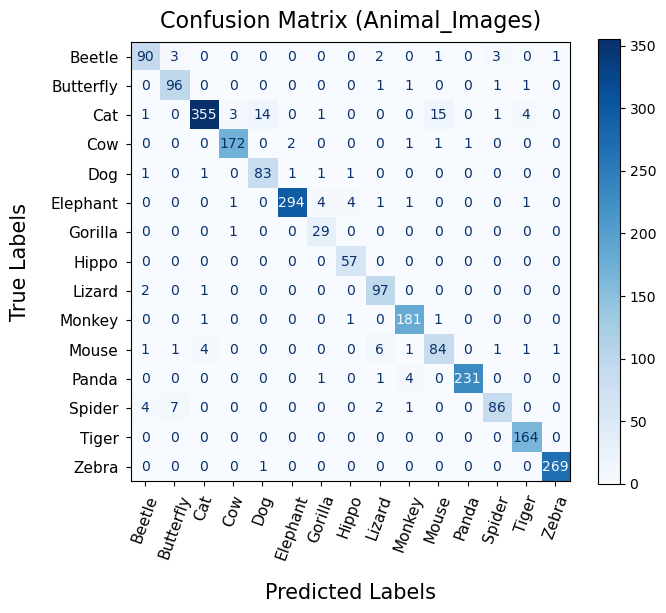



 scikit-learn report: 
              precision    recall  f1-score      support
Beetle         0.909091  0.900000  0.904523   100.000000
Butterfly      0.897196  0.960000  0.927536   100.000000
Cat            0.980663  0.901015  0.939153   394.000000
Cow            0.971751  0.971751  0.971751   177.000000
Dog            0.846939  0.943182  0.892473    88.000000
Elephant       0.989899  0.960784  0.975124   306.000000
Gorilla        0.805556  0.966667  0.878788    30.000000
Hippo          0.904762  1.000000  0.950000    57.000000
Lizard         0.881818  0.970000  0.923810   100.000000
Monkey         0.952632  0.983696  0.967914   184.000000
Mouse          0.823529  0.840000  0.831683   100.000000
Panda          0.995690  0.974684  0.985075   237.000000
Spider         0.934783  0.860000  0.895833   100.000000
Tiger          0.959064  1.000000  0.979104   164.000000
Zebra          0.992620  0.996296  0.994455   270.000000
accuracy       0.950561  0.950561  0.950561     0.950561
macro 

In [16]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Evaluation of model
predictions = trainer.predict(test_data)

# Ids of True Labels
labels_true = predictions.label_ids
# Ids of predicted labels
labels_pred = np.argmax(predictions.predictions, axis=-1)

# Configs for label <-> id mapping
id2label = model.config.id2label
label2id = model.config.label2id

# Plot of confusion matrix
result_confusion = confusion_matrix(labels_true, labels_pred)

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=result_confusion, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=70, values_format="d", ax=ax)

ax.set_xlabel("Predicted Labels", fontsize=15, labelpad=15)
ax.set_ylabel("True Labels", fontsize=15, labelpad=15)
ax.set_title("Confusion Matrix (Animal_Images)", fontsize=16, pad=10)

ax.tick_params(axis="x", labelsize=11, pad=5)
ax.tick_params(axis="y", labelsize=11, pad=5)
plt.tight_layout()

output_path = f"{output_dir}/confusion_matrix.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()


# Output of sklearn classification report
report = classification_report(
    labels_true,
    labels_pred,
    target_names=labels,
    output_dict=True,
)

report_df = pd.DataFrame(report).transpose()

print(f"\n\n scikit-learn report: \n{report_df}")

report_df.to_csv(f"{output_dir}/classification_report.csv", index=True)